<H1> Korimako detection in audio recordings from the Cacophony Project </H1>

Following on the work done with scoring using the [Yamnet](https://tfhub.dev/google/yamnet/1) neural network, this notebook explores whether it's possible to use the features generated by the Yamnet neural network to train a bellbird detector.

See the [Part 1 notebook](./Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for more background.

The basic idea is that when processing audio files, in addition to a classification Yamnet produces a series of 1024-D vectors which can be treated as an embedding. Since Yamnet is an extensively trained network able to classify more than 500 different sounds it's very likely to have considerable utility in transfer learning as a feature generator. Once the embeddings are generated it should be possible to generate a more specific model to recogize particular sounds such as a Korimako (Bellbird) detector by training with relatively little data


In [1]:
import csv
import io
import os
import os.path
import glob
import datetime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patches
from IPython import display
import pydub
import librosa
import soundfile as sf
import nlpaug
import nlpaug.augmenter.audio as naa
from scipy import signal
import pandas as pd
 


# Common code moved to utils:
import utils

In [2]:
SAMPLE_RATE = 16000 # Work at 16000 sampling rate
LOW_PASS_CUTOFF = 4000
HIGH_PASS_CUTOFF = 2000

BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE = 1024

<H2> Data Augmention </H2>
Data augmentation is a way to stretch a little bit more out of a set of small set of training data by generating modified copies of the original data. This can be done by taking subsets, adjusting volume, adding noise and other considerations. 

Data augmentation will be performed with the assistance of the [nlpg](https://github.com/makcedward/nlpaug) package

In [4]:
korimako_test = utils.load_audio_16k_mono("korimako_data/training/korimako/bellbird-56.mp3", end_time=1000)


In [5]:
display.Audio(korimako_test,rate=SAMPLE_RATE )

Remove silence is from [this useful project](https://github.com/laanlabs/train_detector)

In [6]:
def remove_silence(waveform, top_db=50, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves

In [7]:
def augment_data(wav_data, sample_rate, crop_prob, speed_prob, pitch_prob,
                 noise_prob, loudness_prob, verbose=False):
    
    
    """
    Perform random augmentations on the data in wav_data (a numpy array sampled at "sample_rate")
    
    The following parameters are used to control the probability of the associated actions:
        crop_prob: extracting a random segment of the input
        speed_prob: adjusting the speed
        pitch_prob: making a small adjustment to the pitch
        noise_prob: adding random noise
        loudness_prob: adding random noise
        
    If verbose=True then  information about which actions are being applied will be printed
    
    The modified wave data is returned
    
    """

    wd = wav_data
    
    # Extracting out a randomly sized segment of the file.
    if np.random.uniform() < crop_prob:
        length = len(wd)
        # Start anywhere in the first 70% of the sample
        start = int(np.random.uniform() * length * 0.70)
        # Select random end point in what remains, but with bias towards slightly longer extracts
        end = min(int((start + (length-start) * np.random.uniform())*1.5),length)
        if verbose:
            print("Extracting between {:3.1f}s and {:3.1f}".format(start/sample_rate,end/sample_rate))
        wd = wd[start:end]
     
    # Adjusting speed
    if np.random.uniform() < speed_prob:
        speed_aug = naa.SpeedAug(zone=(0,1.0),coverage=1.0,factor=(0.90,1.10))
        if verbose:
            print("Adjusting speed")
        wd = speed_aug.augment(wd)
    
    
    # Adjusting pitch:
    if np.random.uniform() < pitch_prob:
        pitch_aug = naa.PitchAug(zone=(0,1.0),coverage=1.0,sampling_rate=sample_rate, factor=(0.8,2.0))
        if verbose:
            print("Adjusting pitch")
        wd = pitch_aug.augment(wd)
        
    # Adding noise:  
    if np.random.uniform() < noise_prob:
        noise_aug = naa.NoiseAug(zone=(0,1.0),coverage=1.0,color='pink')
        if verbose:
            print("Adding noise")
        wd = noise_aug.augment(wd)
        
      
    # Adjusting loudness:
    if np.random.uniform() < loudness_prob:
        loudness_aug = naa.LoudnessAug(zone=(0,1.0),coverage=1.0, factor=(0.2,2.0))
        if verbose:
            print("Adjusting loudness")
        wd = loudness_aug.augment(wd)
        
    return wd

        
    

In [8]:
aug_korimako_test = remove_silence(augment_data(korimako_test,SAMPLE_RATE,crop_prob =1.0, speed_prob = 0.5, pitch_prob=0.5, 
                                                  noise_prob = 0.6, loudness_prob=0.5))
display.Audio(aug_korimako_test,rate=SAMPLE_RATE )

<H2> Loading Training and Test Data </H2>

In [9]:
yamnet_model,_ = utils.load_model_and_class_names()

2021-09-17 15:21:57.066874: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-17 15:22:02.029327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
def load_data(base_dir, labels_direc, yamnet_model, num_augments, crop_prob, 
              speed_prob, pitch_prob, noise_prob, loudness_prob, top_db):
    """
    Load training data
    
    In base_dir there should be a training/ and a test/ dir. In each there should be sub-dirs that are keys
    in in label_direc. For each directory:
        - read each .mp3 file present
        - augment it num_augments times
        - process it with the yamnet_model to get the list of 1024 vectors
        - add the vector to training_data or test_data, along with the associated label from labels_direc
            to training_labels and test_labels
    
    Then the training and test data are both randomly shuffled
    
    
    num_augments: The number of augmentations to be generated. If zero then no augmentation is performed. 
    
    The following parameters are used to control the probability of the associated actions in data augmentation:
        
        crop_prob: extracting a random segment of the input
        speed_prob: adjusting the speed
        pitch_prob: making a small adjustment to the pitch
        noise_prob: adding random noise
        loudness_prob: adding random noise
        
    top_db is the threshold for defining "silence" in remove_silence()
    
    
    return a tuple of (training_data, training_labels, test_data, test_labels)
    """
    
    dirs = ["training", "test"]
    
    
    
    for d in dirs:
        # For testing and training directories
        
        data = []
        labels = []
        
        for sd in labels_direc:
            label = labels_direc[sd]
            
            path = os.path.join(base_dir,d,sd)
            print("In directory: {}".format(path))
            
            files = glob.glob("{}/*.mp3".format(path))
            for f in files:
                print("  Processing file: {}".format(f))
                pathname,filename = os.path.split(f)
                basename = os.path.splitext(filename)[0]
                
                wav_data = utils.load_audio_16k_mono(f, end_time=1000)
                
                
                augmented_data = []
                
                if num_augments == 0: # No augmentations
                    augmented_data.append(wav_data)
                    
                else:
                    for iaug in range(num_augments):
                        augmented_data.append(remove_silence(augment_data(wav_data,SAMPLE_RATE, crop_prob,
                                                speed_prob, pitch_prob, noise_prob , loudness_prob),top_db=top_db))
                    
                for iaug,aug_data in enumerate(augmented_data):
                     
                    fn = os.path.join(pathname, "processed","{}_{}.wav".format(basename,iaug))
                    sf.write(fn,aug_data,SAMPLE_RATE)
                    _,embeddings,_ = yamnet_model(aug_data)
                                
                    #print("    There are {:3d} frames in the file".format(len(embeddings)))
                    
                    for frame in range(len(embeddings)):
                        data.append(embeddings[frame,:])
                        labels.append(label)
        
        
        data = np.array(data)
        labels = np.array(labels)
        assert(len(data) == len(labels))
        
        
    
        if d == "training":
            training_data = data
            training_labels = labels
        else:
            test_data = data
            test_labels = labels
    
    # Print some statistics:
    
    num_test = len(test_data)
    num_training = len(training_data)
    total = num_test + num_training
    print("\nThere are {:4d} training data items".format(num_training))
    print("There are {:4d} test data items".format(num_test))
    
    print("\nTraining:Test ratio is {:2d}:{:2d}".format(round(100*num_training/total),round(100*num_test/total)))
    
    # Want mean scores to be close to 0.5 so we have about the same number as positives as negatives
    print("\nMean training label = {:3.2f}".format(np.mean(training_labels)))
    print("Mean test label     = {:3.2f}".format(np.mean(test_labels)))
    
    return (training_data,training_labels,test_data,test_labels)
            
        
        

In [13]:
labels_direc = {"korimako" : 1, "not_korimako" : 0}
# For augmentation it seems NOT adjusting the speed or pitch gives better results
train_data,train_labels, test_data, test_labels = load_data("korimako_data", labels_direc, yamnet_model,
                                                  num_augments = 5,
                                                  crop_prob =1.0, 
                                                  speed_prob = 0.0, 
                                                  pitch_prob=0.0, 
                                                  noise_prob = 0.6, 
                                                  loudness_prob=0.5,
                                                  top_db=15)         

In directory: korimako_data/training/korimako
  Processing file: korimako_data/training/korimako/bellbird_2.mp3
  Processing file: korimako_data/training/korimako/Bellbirdcall.mp3
  Processing file: korimako_data/training/korimako/23 - Track 23_0.mp3
  Processing file: korimako_data/training/korimako/Bellbird male song Kaikoura Dec 2011.mp3
  Processing file: korimako_data/training/korimako/08a_0.mp3
  Processing file: korimako_data/training/korimako/26 - Track 26_1.mp3
  Processing file: korimako_data/training/korimako/Bellbird (Poor Knights).mp3
  Processing file: korimako_data/training/korimako/bellbird_chours1.mp3
  Processing file: korimako_data/training/korimako/bellbird-06.mp3
  Processing file: korimako_data/training/korimako/12a.mp3
  Processing file: korimako_data/training/korimako/NIA 104 NZ Bellbird.mp3
  Processing file: korimako_data/training/korimako/29 - Track 29_0.mp3
  Processing file: korimako_data/training/korimako/bellbird-56.mp3
In directory: korimako_data/trainin

In [14]:
# Convert to TF datasets, batch and shuffle

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print("There are {:3d} training batches".format(len(train_dataset)))
print("There are {:3d} test batches".format(len(test_dataset)))
   

There are  44 training batches
There are  10 test batches


<H2> Creating a classifcation model </H2>

A couple of Dense layers should be sufficient to classify the embeddings into Korimako or not Korimako



In [15]:
def plot_history(history,num_epochs):
    """
    Plot the training and validation loss and accuracy per epoch in history
    """
    
    # Linewidth and colors for plot
    lw = 3
    train_color = '#6655DD'
    val_color = '#DD5566'
    
    plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
   
   
    
    x = np.arange(num_epochs,dtype='float32')
    x += 1
    
    ax1.plot(x,history.history['loss'],c=train_color,linewidth=lw,label='Training Loss')
    ax1.plot(x,history.history['val_loss'],c=val_color,linewidth=lw,label='Test Loss')
    ax1.set_title("Loss from training classification model")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(x,history.history['accuracy'],c=train_color,linewidth=lw,label='Training Accuracy')
    ax2.plot(x,history.history['val_accuracy'],c=val_color,linewidth=lw,label='Test Accuracy')
    ax2.set_title("Accuracy from training classification model")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
                               
    

In [16]:
def create_classifcation_model(num_classes,num_hidden_units,
                               dropout,
                               hidden_activation, input_size):
    """
    Create a classification model
    
    num_classes will be the output of the final layer
    
    There will be N hidden layers with num_hidden_units[n] and dropout[2] for each
    using activation of "hidden_activation"
    
    """
    assert( len(num_hidden_units) == len(dropout))
    assert( len(num_hidden_units) > 0)
    

    input_layer = tf.keras.layers.Input(shape=(input_size,), name="Input")
    
    x = input_layer
    
    for i,units in enumerate(num_hidden_units):
        x = tf.keras.layers.Dense(units, activation=hidden_activation, name='Dense_{}'.format(i+1))(x)
        x = tf.keras.layers.Dropout(dropout[i], name='Dropout_{}'.format(i+1)) (x)
   
    
    if num_classes == 1:
        output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    else:
        output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    
    return model

In [17]:
tf.keras.backend.clear_session()

classification_model = create_classifcation_model(num_classes=1,num_hidden_units=[512,256],dropout=[0.2,0.2],
                                    hidden_activation='relu',input_size=1024)

classification_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0
_______________________________________________________

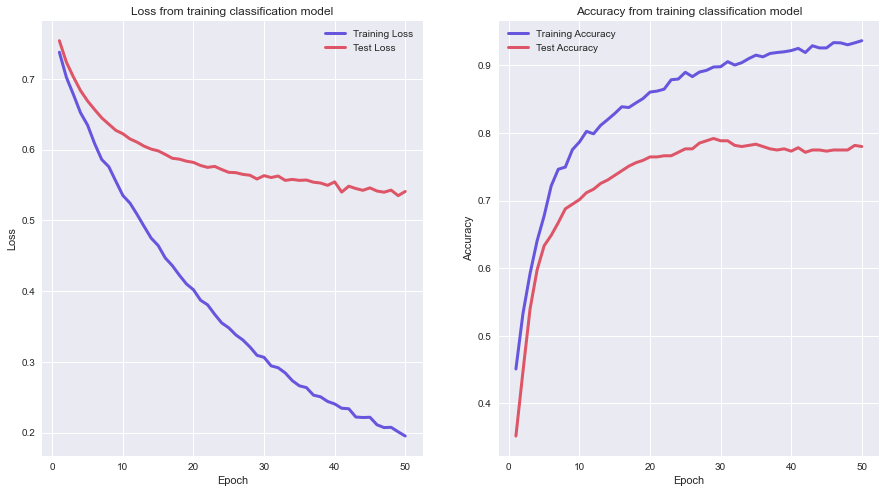

In [18]:
# Use Adam optimizer and Binary Categorical Cross Entropy as the loss, accuracy as the metric


adam_opt=tf.keras.optimizers.Adam(learning_rate=0.00001)
#rms_prop_opt=tf.keras.optimizers.RMSprop(learning_rate=0.00001,momentum=.9)


classification_model.compile(loss='binary_crossentropy', optimizer=adam_opt,metrics=['accuracy'])


NUM_EPOCHS = 50
history = classification_model.fit(train_dataset,epochs=NUM_EPOCHS, validation_data=test_dataset, verbose=0)

plot_history(history,NUM_EPOCHS)

In [19]:
classification_model.save('korimako_model.h5')

In [23]:
def apply_classification_model(filename,classification_model, yamnet_model ):
    """
    Apply the Yamnet and classification models to the audio data in filename
    Return the score - the mean number of bellbird classifications
    
    """
    
    wav_data = utils.load_audio_16k_mono(filename, end_time=10000)
    wav_data = remove_silence(wav_data,top_db=15)
    
    _,embeddings,_ = yamnet_model(wav_data)
                                
          
    
    data = []
    for frame in range(len(embeddings)):
        data.append(embeddings[frame,:])
    
    data = np.array(data)
    predictions = classification_model.predict(data)
    
    score = np.mean(predictions,axis=0)
    
    return score[0]
    
    
    

In [24]:
def validate_model(path,classification_model, yamnet_model):
    """
    For each file in path, apply the classification model and print the probability of being a bellbird

    """
    print("Probability of bellbird for validation files\n")
    
    print("{:30s}{:5s}".format("File","Prob."))
    print("-"*35)
    for f in glob.glob("{}/*.mp3".format(path)):
        score = apply_classification_model(f,classification_model,yamnet_model)
        print("{:30s} {:3.2f}".format(os.path.basename(f),score))

In [25]:
validate_model("korimako_data/validation",classification_model,yamnet_model)

Probability of bellbird for validation files

File                          Prob.
-----------------------------------
goose.mp3                      0.46
tui.mp3                        0.45
greywarbler.mp3                0.22
korimako1.mp3                  0.67
korimako2.mp3                  0.89


<H2> A convolution based classifcation model </H2>
Will the performance of a series of 1D convlutions be better for this dataset?

In [26]:
def create_conv_classification_model(num_classes,num_filters,
                               kernel_sizes,strides,
                               hidden_activation, dense_units,input_size):
    """
    Create a classification model
    
    num_classes will be the output of the final layer
    
    There will be N hidden layers with num_hidden_units[N] 
    using activation of "hidden_activation" each with kernel_sizes[N] and strides[N]
    
    Two final dense layers. One with "dense_units" and one with num_classes
    
    """
    assert( len(num_filters) == len(kernel_sizes))
    assert( len(num_filters) == len(strides))
    assert( len(num_filters) > 0)
    
   

    input_layer = tf.keras.layers.Input(shape=(input_size,1,), name="Input")
    
    x = input_layer
    
    
    for i,filters in enumerate(num_filters):
        x = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_sizes[i], strides=strides[i],
                                   padding = 'valid', activation=hidden_activation, name='Conv1D_{}'.format(i+1))(x)
        x = tf.keras.layers.MaxPool1D(name='MaxPooling1D_{}'.format(i+1)) (x)
   
    
    x = tf.keras.layers.Flatten(name="Flatten")(x)
    x = tf.keras.layers.Dense(dense_units, activation=hidden_activation, name="Dense_1")(x)
  
    if num_classes == 1:
        output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="SigmoidDense")(x)
    else:
        output = tf.keras.layers.Dense(num_classes, activation='softmax', name="SoftmaxDense")(x)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    
    return model

In [27]:
tf.keras.backend.clear_session()

classification_conv_model = create_conv_classification_model(num_classes=1,num_filters=[64,32,16],kernel_sizes=[2,2,2],
                                    strides=[2,2,2],hidden_activation='relu',dense_units=128,input_size=1024)

classification_conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1024, 1)]         0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 512, 64)           192       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 256, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 128, 32)           4128      
_________________________________________________________________
MaxPooling1D_2 (MaxPooling1D (None, 64, 32)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 16)            1040      
_________________________________________________________________
MaxPooling1D_3 (MaxPooling1D (None, 16, 16)            0     

Epoch 1/200
44/44 [==============================] - 2s 34ms/step - loss: 0.6969 - accuracy: 0.4907 - val_loss: 0.6864 - val_accuracy: 0.5273
Epoch 2/200
44/44 [==============================] - 1s 31ms/step - loss: 0.6747 - accuracy: 0.6888 - val_loss: 0.6630 - val_accuracy: 0.7901
Epoch 3/200
44/44 [==============================] - 1s 30ms/step - loss: 0.6609 - accuracy: 0.7459 - val_loss: 0.6428 - val_accuracy: 0.7918
Epoch 4/200
44/44 [==============================] - 1s 31ms/step - loss: 0.6420 - accuracy: 0.7373 - val_loss: 0.6209 - val_accuracy: 0.7867
Epoch 5/200
44/44 [==============================] - 1s 31ms/step - loss: 0.6231 - accuracy: 0.7473 - val_loss: 0.6006 - val_accuracy: 0.7867
Epoch 6/200
44/44 [==============================] - 1s 30ms/step - loss: 0.5977 - accuracy: 0.7505 - val_loss: 0.5809 - val_accuracy: 0.7799
Epoch 7/200
44/44 [==============================] - 1s 32ms/step - loss: 0.5707 - accuracy: 0.7552 - val_loss: 0.5634 - val_accuracy: 0.7816
Epoch 

44/44 [==============================] - 1s 31ms/step - loss: 0.0602 - accuracy: 0.9836 - val_loss: 0.5608 - val_accuracy: 0.8498
Epoch 116/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0633 - accuracy: 0.9807 - val_loss: 0.5777 - val_accuracy: 0.8447
Epoch 117/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0594 - accuracy: 0.9818 - val_loss: 0.5801 - val_accuracy: 0.8430
Epoch 118/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0568 - accuracy: 0.9814 - val_loss: 0.5602 - val_accuracy: 0.8515
Epoch 119/200
44/44 [==============================] - 1s 30ms/step - loss: 0.0596 - accuracy: 0.9804 - val_loss: 0.5607 - val_accuracy: 0.8515
Epoch 120/200
44/44 [==============================] - 1s 30ms/step - loss: 0.0567 - accuracy: 0.9832 - val_loss: 0.6057 - val_accuracy: 0.8413
Epoch 121/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0552 - accuracy: 0.9818 - val_loss: 0.5779 - val_accuracy: 0.8481
Epoch 

Epoch 172/200
44/44 [==============================] - 1s 29ms/step - loss: 0.0248 - accuracy: 0.9943 - val_loss: 0.6867 - val_accuracy: 0.8584
Epoch 173/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0244 - accuracy: 0.9950 - val_loss: 0.6273 - val_accuracy: 0.8601
Epoch 174/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0257 - accuracy: 0.9936 - val_loss: 0.6938 - val_accuracy: 0.8584
Epoch 175/200
44/44 [==============================] - 1s 30ms/step - loss: 0.0231 - accuracy: 0.9946 - val_loss: 0.6432 - val_accuracy: 0.8601
Epoch 176/200
44/44 [==============================] - 1s 31ms/step - loss: 0.0235 - accuracy: 0.9961 - val_loss: 0.6783 - val_accuracy: 0.8601
Epoch 177/200
44/44 [==============================] - 1s 32ms/step - loss: 0.0227 - accuracy: 0.9946 - val_loss: 0.6915 - val_accuracy: 0.8584
Epoch 178/200
44/44 [==============================] - 1s 30ms/step - loss: 0.0218 - accuracy: 0.9957 - val_loss: 0.6646 - val_accuracy:

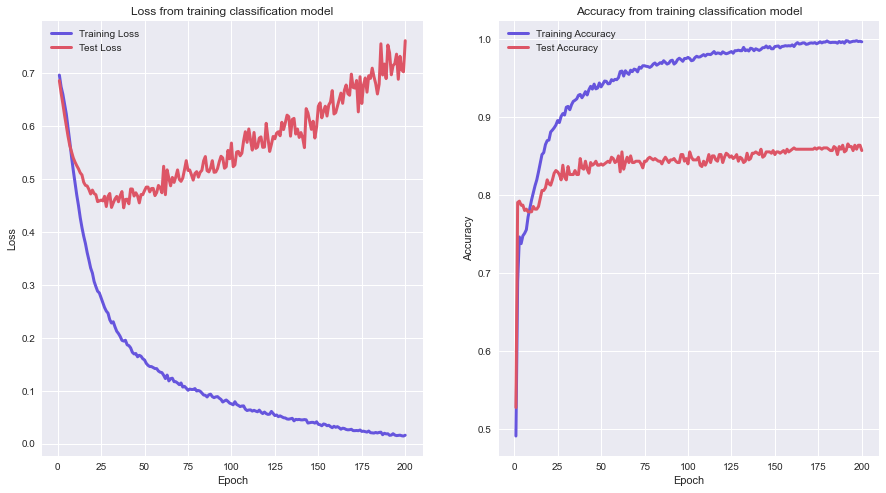

In [28]:
# Use Adam optimizer and Binary Categorical Cross Entropy as the loss, accuracy as the metric


adam_opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
#rms_prop_opt=tf.keras.optimizers.RMSprop(learning_rate=0.00001,momentum=.9)


classification_conv_model.compile(loss='binary_crossentropy', optimizer=adam_opt,metrics=['accuracy'])


NUM_EPOCHS = 200
conv_history = classification_conv_model.fit(train_dataset,epochs=NUM_EPOCHS, validation_data=test_dataset, verbose=1)

plot_history(conv_history,NUM_EPOCHS)

In [29]:
validate_model("korimako_data/validation",classification_conv_model,yamnet_model)

Probability of bellbird for validation files

File                          Prob.
-----------------------------------
goose.mp3                      0.63
tui.mp3                        0.42
greywarbler.mp3                0.01
korimako1.mp3                  0.71
korimako2.mp3                  0.97


<H2> Examining the embeddings </H2>

A closer look at the embeddings generated by yamnet in order to assess how best to build a model based on them.

In [30]:
korimako1_audio = utils.load_audio_16k_mono("korimako_data/validation/korimako1.mp3", end_time=3)
korimako2_audio = utils.load_audio_16k_mono("korimako_data/validation/korimako2.mp3", end_time=3)
goose_audio = utils.load_audio_16k_mono("korimako_data/validation/goose.mp3", end_time=3)

In [31]:
display.Audio(korimako1_audio,rate=SAMPLE_RATE )

In [32]:
display.Audio(korimako2_audio,rate=SAMPLE_RATE )

In [33]:
display.Audio(goose_audio,rate=SAMPLE_RATE )

In [34]:
_,korimako1_emb,_ = yamnet_model(korimako1_audio)
_,korimako2_emb,_ = yamnet_model(korimako2_audio)
_,goose_emb, _ = yamnet_model(goose_audio)
korimako1_emb = korimako1_emb.numpy()
korimako2_emb = korimako2_emb.numpy()
goose_emb = goose_emb.numpy()

In [35]:
korimako1_emb.shape,korimako2_emb.shape,goose_emb.shape

((6, 1024), (6, 1024), (6, 1024))

Are the vectors normalized?

In [36]:
np.sum(korimako1_emb,axis=1)

array([96.7735  , 94.523544, 95.77983 , 79.53392 , 80.4124  , 69.162476],
      dtype=float32)

In [37]:
np.sum(korimako2_emb,axis=1)

array([ 64.073135, 110.417496, 104.46945 ,  70.129944, 102.115326,
        89.07355 ], dtype=float32)

In [38]:
np.sum(goose_emb,axis=1)

array([ 92.276375, 103.51724 , 100.22165 ,  51.018944,  71.76607 ,
       107.11574 ], dtype=float32)

In [39]:
np.max(korimako1_emb,axis=1)

array([3.6108217, 4.4973717, 5.047609 , 4.356912 , 3.6728213, 3.646773 ],
      dtype=float32)

In [40]:
np.max(korimako2_emb,axis=1)

array([3.432764 , 3.6325264, 3.6511028, 2.6802356, 4.1962867, 4.861614 ],
      dtype=float32)

In [41]:
np.max(goose_emb,axis=1)

array([3.9298775, 3.784754 , 4.3203163, 2.9014657, 3.3499327, 3.3461335],
      dtype=float32)

In [42]:
np.mean(korimako1_emb,axis=1)

array([0.09450537, 0.09230815, 0.09353499, 0.07766984, 0.07852773,
       0.06754148], dtype=float32)

In [43]:
np.mean(korimako2_emb,axis=1)

array([0.06257142, 0.10782959, 0.10202095, 0.06848627, 0.099722  ,
       0.08698589], dtype=float32)

In [44]:
np.mean(goose_emb,axis=1)

array([0.09011365, 0.10109106, 0.0978727 , 0.04982319, 0.07008405,
       0.10460521], dtype=float32)

In [45]:
np.argmax(korimako1_emb,axis=1)

array([1008,  272,  862,  862,  928,  928])

In [46]:
np.argmax(korimako2_emb,axis=1)

array([321, 280, 280,  62, 984, 909])

In [47]:
np.argmax(goose_emb,axis=1)

array([513, 216, 513, 389,  62,  62])

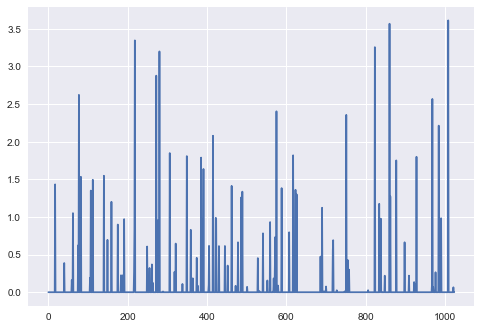

In [48]:
plt.plot(korimako1_emb[0,:])

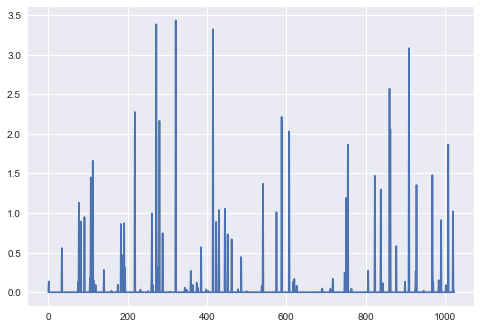

In [49]:
plt.plot(korimako2_emb[0,:])

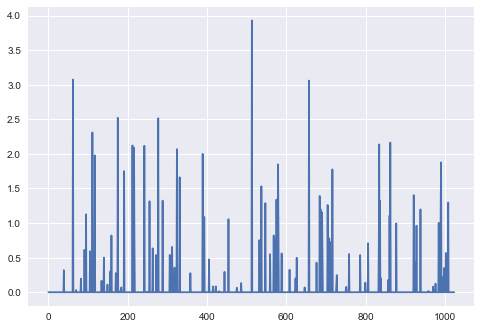

In [50]:
plt.plot(goose_emb[0,:])